# Phase Modulation test
- https://www.allaboutcircuits.com/textbook/radio-frequency-analysis-design/radio-frequency-modulation/phase-modulation-theory-time-domain-frequency-domain/

In [1]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if len(target_path) * len(current_path) > 0:
            if target_path[0] == current_path[0]:
                target_path.pop(0)
                current_path.pop(0)
                del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [2]:
# paths = ['']
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [3]:
paths = [['..', '..', '..', '..', '..', 'Waves', 'bitbucket', 'github', 'codes'],
         ['..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [4]:
%pylab inline

from waves.sound import * 
from waves.tools.dsp.mixers.modulators.analog import *

Populating the interactive namespace from numpy and matplotlib


In [5]:
import warnings 

warnings.filterwarnings('ignore')

In [6]:
def show_pair(sig_left, sig_right, frames = 300):
    sig_left.show(color = 'red', show_frames = slice(0, frames))
    sig_right.show(color = 'green', show_frames = slice(0, frames))
    plt.xticks(rotation = 45)    

## LO

In [7]:
phase_shift = PI2 / 8

In [8]:
freq_lo = int(1e4)

freq_sampling = freq_lo * 8 * 2

In [9]:
duration_seconds = 1
t = np.linspace(0, duration_seconds, duration_seconds * freq_sampling)

## IF

In [10]:
freq_if = int(1e3)

### QPSK

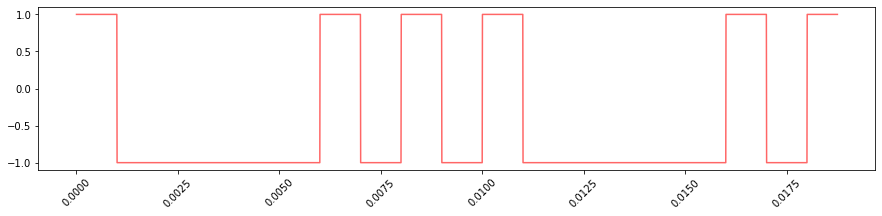

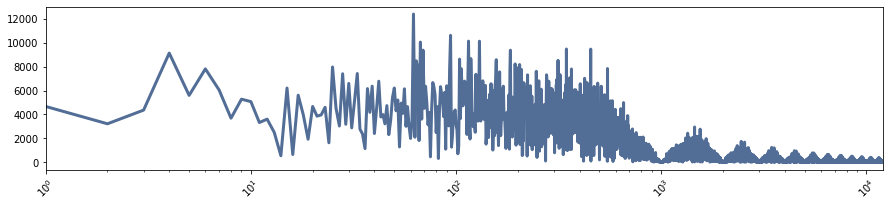

In [11]:
freq_if = 1000

def gen_bitstream(freq, ts):
    bs = np.zeros(ts.shape)
    bs[:] = 1
    n = ts.shape[-1]
    for i in range(1, n):
        if int(freq * ts[i] ) > int(freq * ts[i -1] ) :
            bs[i] = random.choice((-1, 1))
        else :
            bs[i] = bs[i-1]
    return bs

plt.figure(figsize = (15, 3))

# show_frames = 300
# baseband = FrequencyMixer(freq_if, np.cos).gen_channel(t)
# baseband.show(color = 'red', show_frames = slice(0, show_frames))

show_frames = 3000
baseband = Channel(gen_bitstream(freq_if, t), ts = t, framerate = freq_sampling)
baseband.show(color = 'red', show_frames = slice(0, show_frames))
 
plt.xticks(rotation = 45);
plt.figure(figsize = (15, 3))
baseband.make_spectrum().plot(freq_lims = (1, freq_lo + freq_if * 2))
plt.xticks(rotation = 45);

## Modulation

$
\begin{align}
 xPM(t) &=\sin(\omega_c t + xBB(t)) \\ 
\end{align}
$


$
\begin{align}
if \space \omega_c &= 10^7 2 \pi \\ 
 xBB(t) &= \sin(\omega_{BB} t) \\
 xPM(t) &= \sin(\omega_c t +xBB(t)) \\   
         &= \sin(\omega_c t + \sin(\omega_{BB} t)) \\   
\end{align}
$


#### modulation_index
- https://en.wikipedia.org/wiki/Frequency_modulation#Modulation_index

$h={\frac {\Delta {}f}{f_{m}}}={\frac {\Delta {}f}{\frac {1}{2T_{s}}}}=2\Delta {}fT_{s}$

In [12]:
pm = PhaseModulator(freq_lo)#, np.exp)
# pm = PhaseModulator(freq_lo, np.sin)

In [13]:
modulation_index = 4

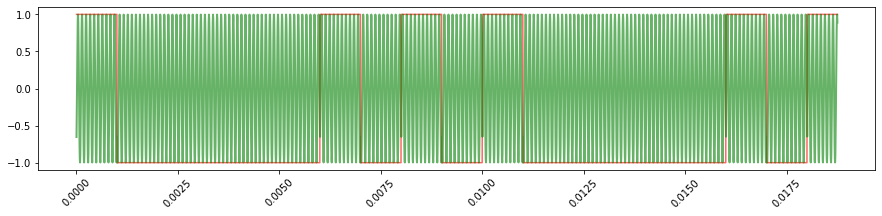

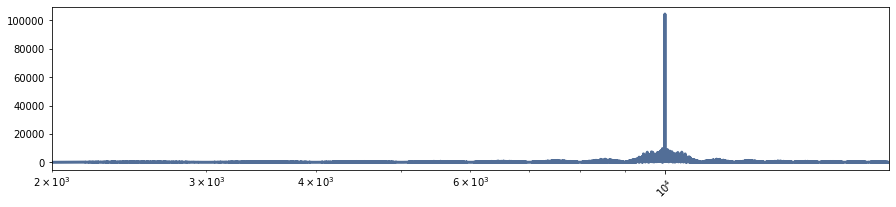

In [14]:
# RF = Channel(np.sin(PI2 * freq_lo * t - modulation_index * np.cos(PI2 * freq_if * t)), t, freq_sampling)  # for xBB(t) = sin()
# RF = Channel(np.sin(PI2 * freq_lo * t + modulation_index * np.sin(PI2 * freq_if * t)), t, freq_sampling)  # for xBB(t) = cos()
RF = pm.modulate(baseband, modulation_index = modulation_index)

plt.figure(figsize = (15, 3))
baseband.show(color = 'red', show_frames = slice(0, show_frames))
RF.show(color = 'green', linewidth = 2, show_frames = slice(0, show_frames))
plt.xticks(rotation = 45);

plt.figure(figsize = (15, 3))
RF.make_spectrum().plot(freq_lims = (freq_lo - freq_if * 8, freq_lo + freq_if * 8))
# RF.make_spectrum().plot(freq_lims = (1, freq_sampling))
plt.xticks(rotation = 45);

- the PM carrier frequency corresponds to the ***slope*** of the baseband waveform
- the highest-frequency sections occur during the steepest positive slope of xBB,
- and the lowest-frequency sections occur during the steepest negative slope.
- in a PM waveform, high baseband slope corresponds to high frequency, and low baseband slope corresponds to low frequency

## De-modulation

$
\begin{align}
 xFM(t) &= e^{j(\omega_c t + m \int_{-\infty}^{t} xBB(t)dt)} \\ 
 xFM(t) \cdot  e^{-j\omega_c t}   &= e^{j(\omega_c t + m \int_{-\infty}^{t} xBB(t)dt)}  e^{-j\omega_c t} \\  
                                 &= e^{j(\omega_c t + m \int_{-\infty}^{t} xBB(t)dt - \omega_c t)}   \\
                                 &= e^{j( m \int_{-\infty}^{t} xBB(t)dt )}   \\
 -j \ln(xFM(t) \cdot  e^{-j\omega_c t}) &=  -j \ln(e^{j( m \int_{-\infty}^{t} xBB(t)dt )})   \\
                                 &=    m \int_{-\infty}^{t} xBB(t)dt )   \\
\end{align}
$

#### 三角函數的乘法:  

$
\begin{align}
 \sin(x) \cos(y) &= (1/2) [\sin(x+y) + \sin(x-y)] \\ 
 \cos(x) \sin(y) &= (1/2) [\sin(x+y) - \sin(x-y)] \\ 
 \cos(x) \cos(y) &= (1/2) [\cos(x-y) + \cos(x+y)] \\ 
 \sin(x) \sin(y) &= (1/2) [\cos(x-y) - \cos(x+y)] \\  
\end{align}
$  

$
\begin{align}
 xFM(t) &= \sin(\omega_c t + m \int_{-\infty}^{t} xBB(t)dt) \\  
 xFM(t) \cdot \sin(\omega_c t ) &= \sin(\omega_c t + m \int_{-\infty}^{t} xBB(t)dt) \cdot \sin(\omega_c t ) \\  
         &= \frac{1}{2} (\cos( m \int_{-\infty}^{t} xBB(t)dt) - \cos(2\omega_c t + m \int_{-\infty}^{t} xBB(t)dt)) \\  
         &\approx \frac{1}{2} (\cos( m \int_{-\infty}^{t} xBB(t)dt)  ) \\  
\end{align}
$


In [15]:
low_pass_cutoff = freq_if * 1

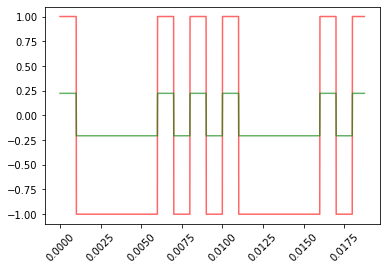

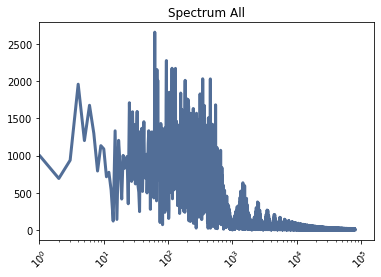

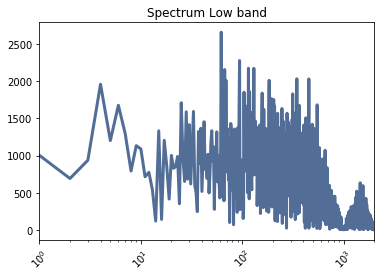

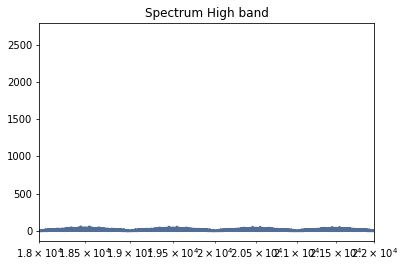

In [16]:
# pm = PhaseModulator(freq_lo, np.exp)

baseband_restored = pm.demodulate(RF, modulation_index = modulation_index)#, remove_dc = True)
# baseband_restored = pm.demodulate_IQ(RF, low_pass_cutoff = low_pass_cutoff) #, modulation_index = modulation_index)#, 

show_pair(baseband, baseband_restored, frames = 3000)

plt.figure()
plt.title('Spectrum All')
baseband_restored.make_spectrum().plot(freq_lims = (1, freq_sampling)) 
plt.xticks(rotation = 45);

plt.figure()
plt.title('Spectrum Low band') 
baseband_restored.make_spectrum().plot(freq_lims = (1, freq_if * 2)) 
# IF_reconstructed.make_spectrum().plot(freq_lims = (freq_if - 10, freq_if + 10)) 
plt.xticks(rotation = 45);

plt.figure()  
plt.title('Spectrum High band')
baseband_restored.make_spectrum().plot(freq_lims = (2*freq_lo - freq_if * 2, 2*freq_lo + freq_if * 2)) 
plt.xticks(rotation = 45);  

## Validate

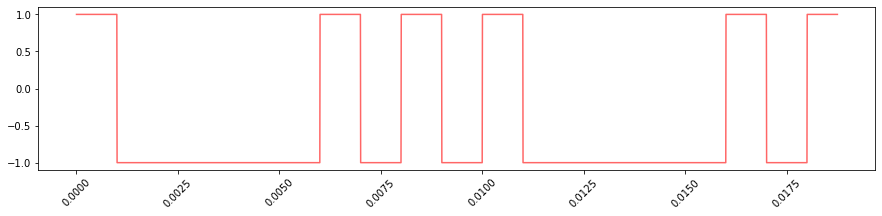

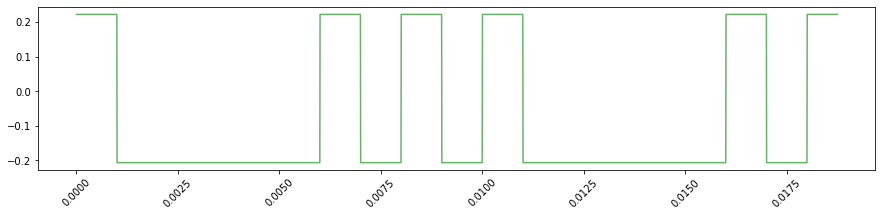

In [17]:
plt.figure(figsize = (15, 3)) 
baseband.show(color = 'red', show_frames = slice(0, show_frames))
plt.xticks(rotation = 45);

plt.figure(figsize = (15, 3)) 
baseband_restored.show(color = 'green', show_frames = slice(0, show_frames))
plt.xticks(rotation = 45);